In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [11]:
#data import and settings
stockstring ='NDAQ'                 # chose a stock symbol from yahoo finance to analyze
period_size = 60                    # days for correlation period
start_date  = datetime(2019, 1, 1)  # date in the past as start_date for analysis, datetime(year, month, day)
end_date    = datetime.today()      # end date for analysis, present date

# factor which excludes (excl_fact * period_size) values the past upto present day from analysis
excl_fact   = 3                     # should be >=2

# Use data prognoses, not fully implemented yet
prognoses = False

In [12]:
# download  stock market data from yahoo finance between start_date and end_date
total_data = yf.download(stockstring, start = start_date, end = end_date, progress = False)

# set up for correlation  reference interval
correlation_ref_end = datetime.today() # end correlation date, typically present dat
correlation_ref_interval = period_size   # days counted back from correlation end date, size of correlation period
correlation_ref_start =  correlation_ref_end - timedelta(days = correlation_ref_interval)
correlation_prog_end =  correlation_ref_end + timedelta(days = correlation_ref_interval)

# create DataFrame for analysis
df = pd.DataFrame(total_data['Close'].tolist())
df['date'] = total_data.index
total_data_list = df[0].tolist()
total_data_len = len(df.index)

# reference Data
ref_data_df = df.loc[df['date'].between(correlation_ref_start, correlation_ref_end, inclusive = True)]
ref_data = ref_data_df[0].tolist()
ref_data_len = len(ref_data_df.index)

# set up for correlation value of each start date, calculated for the next number of days (period_size)
correlations = np.zeros((total_data_len,2))

In [13]:
# calculate the correlation distance using dynamic time warping between each reference period
# and the correlation period
# iterate over all possible start dates of the reference period and calculate the transformation distance
for time_step in range(0, total_data_len - ref_data_len):
    correlation_data = total_data_list[time_step:time_step+ref_data_len]
    distance, path = fastdtw(correlation_data, ref_data, dist = euclidean)
    correlations[time_step, 0]  =  time_step
    correlations[time_step, 1]  =  distance

# the minimum of the calculated transformation distance has the best correlation towards the correlation period
index_min = np.argmin(correlations[0:total_data_len-ref_data_len * excl_fact, 1])
bestfit_date =df['date'][index_min]

# could be used for prognoses but is not fully implemented
if prognoses:
    prog_past_start_date = bestfit_date +  timedelta(days = correlation_ref_interval)
    prog_past_end_date = prog_past_start_date +  timedelta(days = correlation_ref_interval)
    prog_past_data_date_list = pd.date_range(prog_past_start_date, periods=ref_data_len, freq='B')
    prog_past_data_df = df.loc[df['date'].between(prog_past_start_date, prog_past_end_date, inclusive = True)]
    prog_present_end_date = datetime.today() +  timedelta(days = correlation_ref_interval)
    prog_present_date_list_df = pd.date_range(datetime.today(), periods = ref_data_len, freq='B').to_frame()

    total_data.head()
    ticker = yf.Ticker(stockstring)
    total_data = ticker.history(start = start_date, end = end_date)

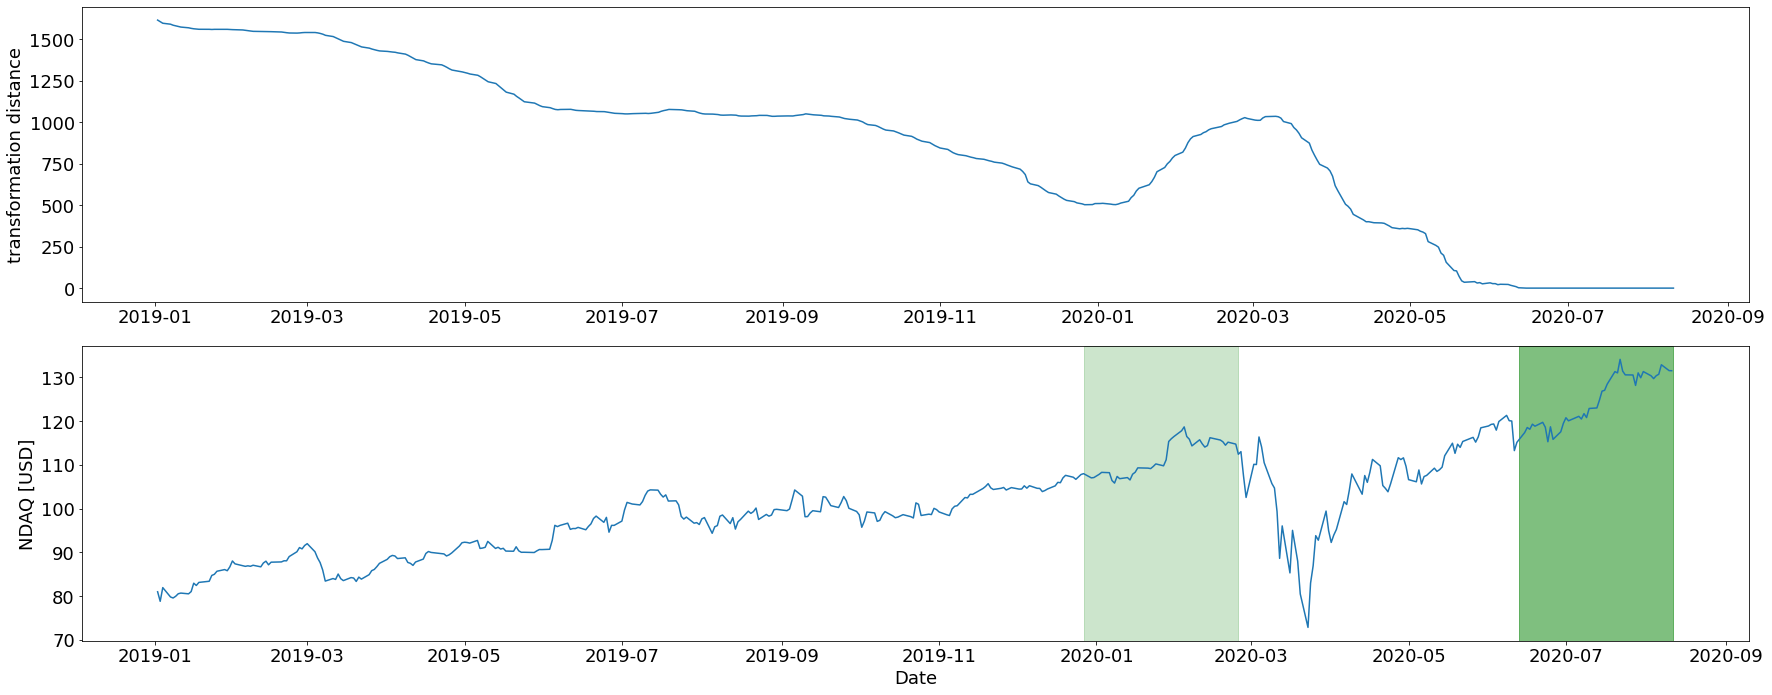

In [16]:
# Data visualisation
fig, axs = plt.subplots(2)
axs[1].plot(df['date'],df[0])
axs[1].axvspan(correlation_ref_start, correlation_ref_end, alpha=0.5, color='green')
axs[1].axvspan(bestfit_date, bestfit_date+timedelta(days=correlation_ref_interval), alpha=0.2, color='green')
axs[0].plot(df['date'],correlations[:,1])

if prognoses:
    plt.setp(axs, xlim=[start_date, prog_present_end_date])

# Set the formatting the same for both subplots
axs[0].tick_params(axis='both', which='both', labelsize = 18)
axs[1].tick_params(axis='both', which='both', labelsize = 18)

plt.setp(axs[1], xlabel='Date')
plt.setp(axs[0], ylabel='transformation distance')
plt.setp(axs[1], ylabel='NDAQ [USD]')

# set ticks visible, if using sharex = True. Not needed otherwise
for tick in axs[0].get_xticklabels():
    tick.set_visible(True)
    
plt.rcParams["figure.figsize"] = (25,10)
plt.rcParams.update({'font.size': 18})

plt.tight_layout()
plt.show()